In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import pydicom
import random
import cv2

import tensorflow.keras

from sklearn.model_selection import train_test_split

PATH = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
random.seed(12345)

## Reading provided data
At first read the CSV file with training data. 

In [2]:
dataframe = pd.read_csv(PATH + "stage_2_train.csv")
dataframe.head(6)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0


As we can see, there are six types of Intracranial Hemorrhages. For easier work with data, create separate columns for ID and hemorrhage type.

In [3]:
split_id = dataframe['ID'].str.split('_', n=2, expand=False)
dataframe[['ID','Type']] = [['_'.join(spl[:2]), spl[-1]] for spl in split_id]
dataframe.head(6)

,ID,Label,Type
0,ID_12cadc6af,0,epidural
1,ID_12cadc6af,0,intraparenchymal
2,ID_12cadc6af,0,intraventricular
3,ID_12cadc6af,0,subarachnoid
4,ID_12cadc6af,0,subdural
5,ID_12cadc6af,0,any


Now we can take a look on the dataset balancing and fraquency of each type. 

In [4]:
epidural_cnt = dataframe[dataframe['Type'] == 'epidural']['Label'].sum()
intraparenchymal_cnt = dataframe[dataframe['Type'] == 'intraparenchymal']['Label'].sum()
intraventricular_cnt = dataframe[dataframe['Type'] == 'intraventricular']['Label'].sum()
subarachnoid_cnt = dataframe[dataframe['Type'] == 'subarachnoid']['Label'].sum()
subdural_cnt = dataframe[dataframe['Type'] == 'subdural']['Label'].sum()
hemorrhages_detected = dataframe[dataframe['Type'] == 'any']['Label'].sum()
none_cnt = dataframe[dataframe['Type'] == 'any']['Label'].count() - hemorrhages_detected

print(f'Dataset contains {hemorrhages_detected} studies with detected intracranial hemorrhage (in one study can be found more than one ICH type):')
print(f'{epidural_cnt} epidural,')
print(f'{intraparenchymal_cnt} intraparenchymal,')
print(f'{intraventricular_cnt} intraventricular,')
print(f'{subarachnoid_cnt} subarachnoid,')
print(f'{subdural_cnt} subdural.')
print(f'And finally, dataset contains {none_cnt} images with no hemorrhage detected.')

Dataset contains 107933 studies with detected intracranial hemorrhage (in one study can be found more than one ICH type):
3145 epidural,
36118 intraparenchymal,
26205 intraventricular,
35675 subarachnoid,
47166 subdural.
And finally, dataset contains 644874 images with no hemorrhage detected.


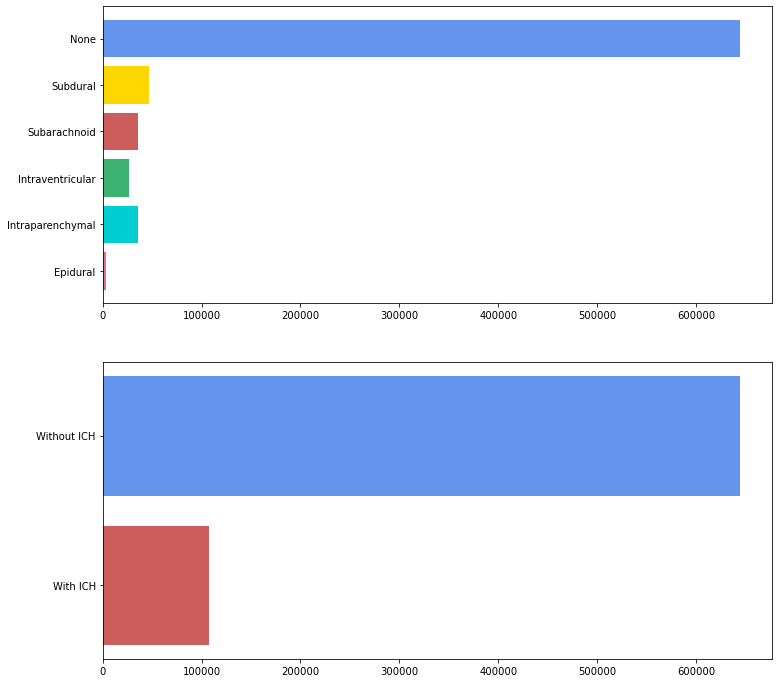

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].barh(['Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'None'], 
           [epidural_cnt, intraparenchymal_cnt, intraventricular_cnt, subarachnoid_cnt, subdural_cnt, none_cnt],
           color = ['palevioletred', 'darkturquoise', 'mediumseagreen', 'indianred', 'gold', 'cornflowerblue'])
axs[1].barh(['With ICH', 'Without ICH'], [hemorrhages_detected, none_cnt], color = ['indianred', 'cornflowerblue'])
fig.show()

The dataset is highly imbalanced. So we'll need to undersample the data with no hemmorage and oversample or augment the data with some hemorrage type detected. (TODO)

## Data preprocessing
We'll look at the informations provided in DICOM file.

In [6]:
sample_img = pydicom.filereader.dcmread(PATH + "stage_2_train/" + dataframe['ID'].values[random.randrange(len(dataframe['ID'].unique()))] + ".dcm")
sample_img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.216203953794358856464117848933436778598
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_7110d1629
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_71fc608a'
(0020, 000d) Study Instance UID                  UI: ID_49269e138d
(0020, 000e) Series Instance UID                 UI: ID_bc8765a545
(0020, 0010) Study ID                            SH: ''
(0020, 00

Interesting parameters for us are Rescale Intercept, Rescale Slope and Pixel Data. Pixel Data contains only the pixels of the image. Rescale parameters are used to rescale values of the pixel array. Thus all images will have pixel values from the same interval.

After rescaling the smallest value of Pixel Data should be around -1000. This value respresents air and every lower value is a pixel which was outside the bounds of CT scanner so the scanner usually sets it to -2000. We'll correct this values to -1000. 

Also because the range of values is large and there is only small range of values in which we are interested, we'll use so-called Brain Window - values from 0 to 80 will be in shades of grey, values lower than 0 black and values greater than 80 white. This makes possible to better see the differences between hemorrhage and brain tissue .

In [7]:
def correct_hu_values(image, rescale_intercept, rescale_slope):
    corrected_image = image + rescale_intercept * rescale_slope
    corrected_image[corrected_image <= -1000] = -1000
    return corrected_image

def apply_window(image, center=40, width=80):
    windowed_image = np.array(image)
    windowed_image[windowed_image < center - width/2] = center - width/2
    windowed_image[windowed_image > center + width/2] = center + width/2
    return windowed_image

def normalize_image(image):
    img_min = min(image.flatten())
    img_max = max(image.flatten())

    if img_min != img_max:
        return (image - img_min)/(img_max - img_min)
    else:
        return image - img_min

In [8]:
def make_hist(graph, data, xlabel, ylabel, title):
    graph.hist(data, bins=100)
    graph.set_xlabel(xlabel)
    graph.set_ylabel(ylabel)
    graph.set_title(title)
    
def make_image(graph, image, title, gray=True):
    graph.imshow(image, cmap=plt.cm.gray)
    graph.set_title(title)

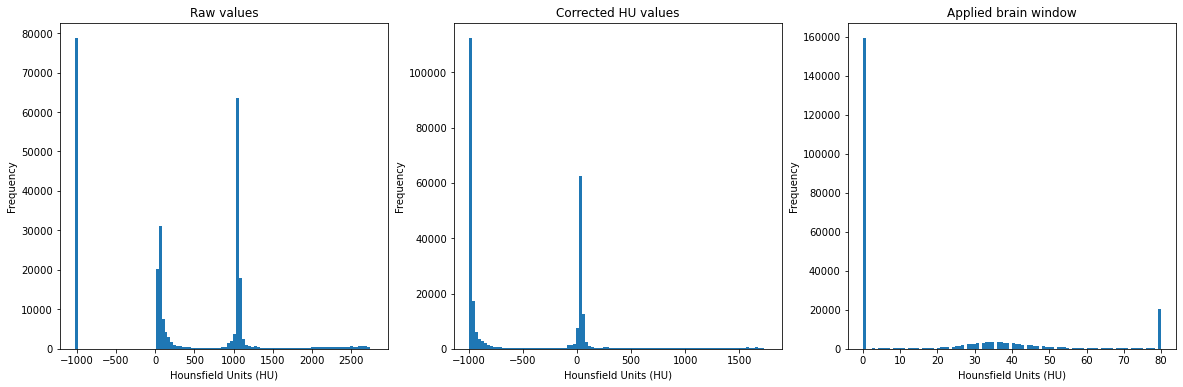

In [9]:
img_pa = sample_img.pixel_array
img_pa_corrected_hu = correct_hu_values(img_pa, sample_img.RescaleIntercept, sample_img.RescaleSlope)
img_pa_window = apply_window(img_pa_corrected_hu, 40, 80)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
make_hist(axs[0], img_pa.flatten(), "Hounsfield Units (HU)", "Frequency", "Raw values")
make_hist(axs[1], img_pa_corrected_hu.flatten(), "Hounsfield Units (HU)", "Frequency", "Corrected HU values")
make_hist(axs[2], img_pa_window.flatten(), "Hounsfield Units (HU)", "Frequency", "Applied brain window")
fig.show()

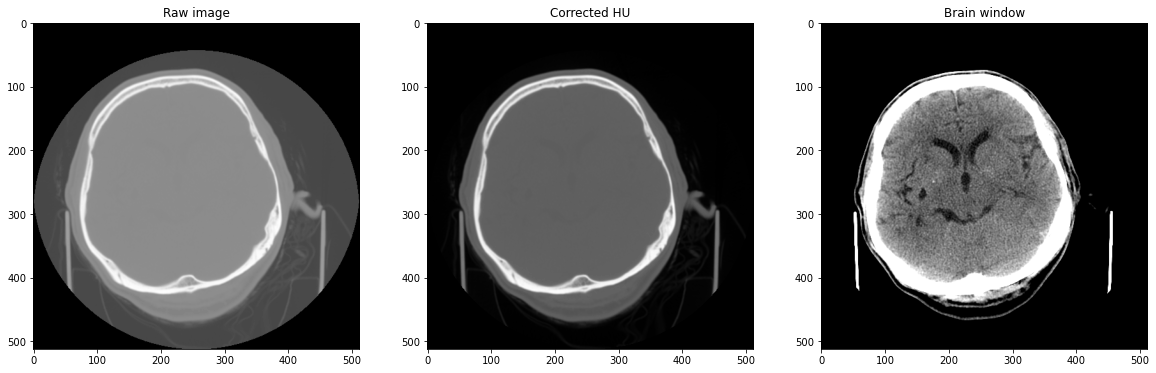

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
make_image(axs[0], img_pa, "Raw image")
make_image(axs[1], img_pa_corrected_hu, "Corrected HU")
make_image(axs[2], img_pa_window, "Brain window")
fig.show()

After preprocessing we must separate data for training and validation and avoid to have the same patient in both datasets. (TODO)

In [12]:
data = np.empty((len(dataframe)//6, 2), dtype=object)
for i in range(len(dataframe)//6):
    tmp = dataframe.loc[i*6:(i+1)*6-1]
    img_id = tmp.loc[i*6]['ID']
    labels = tmp['Label'].values
    data[i] = np.array([img_id, labels], dtype=object)

In [13]:
data

array([['ID_12cadc6af', array([0, 0, 0, 0, 0, 0])],
       ['ID_38fd7baa0', array([0, 0, 0, 0, 0, 0])],
       ['ID_6c5d82413', array([0, 0, 0, 0, 0, 0])],
       ...,
       ['ID_e5c02a4ca', array([0, 0, 0, 0, 0, 0])],
       ['ID_8079930a8', array([0, 0, 0, 0, 0, 0])],
       ['ID_4a85a3a3f', array([0, 0, 0, 0, 0, 0])]], dtype=object)

In [14]:
train_data, valid_data = train_test_split(data, test_size=0.2, train_size=0.8, random_state=123)
print(f'Images in training dataset: {len(train_data)}\nImages in valiation dataset: {len(valid_data)}')

Images in training dataset: 602245
Images in valiation dataset: 150562


In [15]:
X_train = train_data[:,0]
y_train = train_data[:,1]
X_valid = valid_data[:,0]
y_valid = valid_data[:,1]

In the CNN model we'll use the weights from pretrained model on ImageNet, so the images must be resized to apropriate size and coverted to 3-channel.

In [16]:
def resize_img(image, dim=(224, 224)):
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def to_3_channels(channel1, channel2=None, channel3=None):
    if channel2 is None:
        channel2 = channel1
    if channel3 is None:
        channel3 = channel1
    
    image = np.empty((channel1.shape[0], channel1.shape[1], 3))
    image[:,:,0] = channel1
    image[:,:,1] = channel2
    image[:,:,2] = channel3
    
    return image

Because the dataset is to large is necessary to create a data generator for training and validation data.

In [17]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp, indexes):
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            sample = pydicom.filereader.dcmread(PATH + "stage_2_train/" + ID + ".dcm")
            
            sample_pixel_array = sample.pixel_array
            
            sample_pixel_array = correct_hu_values(sample_pixel_array, sample.RescaleIntercept, sample.RescaleSlope)
            sample_pixel_array = apply_window(sample_pixel_array, 40, 80)
            sample_pixel_array = normalize_image(sample_pixel_array)
            
            sample_pixel_array = resize_img(sample_pixel_array, self.dim)
            sample_pixel_array = to_3_channels(sample_pixel_array)
            
            X[i,] = sample_pixel_array
            y[i] = self.labels[indexes[i]]
        
        return X, y
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp, indexes)

        return X, y

In [18]:
training_generator = DataGenerator(X_train, y_train, batch_size=8, dim=(224, 224), n_classes=6, shuffle=True)
validation_generator = DataGenerator(X_valid, y_valid, batch_size=8, dim=(224, 224), n_classes=6, shuffle=True)

## Creating the model
For training the model we'll write our own loss function - weighted multi label log loss which will give more weight to the "any" label. And also we'll create own last layer, because the "any" label will be computed as the maximum of other labels.

In [19]:
def weighted_multi_label_log_loss(y_true, y_pred):
    weights = [1., 1., 1., 1., 1., 2.]
    eps = tf.keras.backend.epsilon()
    
    new_y_true = tf.cast(y_true, tensorflow.float32)
    new_y_pred = tf.keras.backend.clip(y_pred, eps, 1.0-eps)

    out = -(         new_y_true  * tf.keras.backend.log(      new_y_pred) * weights
            + (1.0 - new_y_true) * tf.keras.backend.log(1.0 - new_y_pred) * weights)
    
    return tf.keras.backend.mean(out, axis=-1)

In [20]:
class ComputeAnyLabel(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(ComputeAnyLabel, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    pass

  def call(self, input_tensor):
    input_max = tf.reshape(tf.math.reduce_max(input_tensor,axis=1), (len(input_tensor),1))
    return tf.concat([input_tensor, input_max], 1)

Finally we'll create the model and try to run few epochs.

In [21]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3), pooling="avg", include_top=False)
model = tf.keras.models.Model(inputs=base_model.input, outputs=ComputeAnyLabel(6)(tf.keras.layers.Dense(5, activation="sigmoid")(base_model.output)))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=weighted_multi_label_log_loss,
              metrics=[tf.keras.metrics.AUC(multi_label=True)])

27025408/27018416 [==============================] - 0s 0us/step


In [22]:
for i in range(5):
    model.fit(x=training_generator, epochs=1, steps_per_epoch=2000, shuffle=True, use_multiprocessing=True, workers=8)
    model.evaluate(x=validation_generator, steps=400, use_multiprocessing=True, workers=8)

400/400 [==============================] - 315s 771ms/step - loss: 0.5626 - auc: 0.5000
